In [4]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [5]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats
from sklearn import decomposition
from loading import load_session_data
from target import build_tgt_matrix, get_spike_counts, build_silence_and_noise_events,\
        get_idxs_of_event_periods, build_silence_matrix, get_spike_times_at, build_event_mx
np.set_printoptions(suppress=True)

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

## Compare profiles between BGR / SIL

In [8]:
session = sessions[-5]
session

'009266_hippoSIT_2023-05-22_09-27-22'

In [14]:
hw, bc = 0.25, 31
session_data = load_session_data(session)

tl = session_data['tl']
aeps_events = session_data['aeps_events']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
h5_file = session_data['h5_file']

# BGR periods to compute BGR profiles
periods_bgr = get_idxs_of_event_periods(tl, 1)

# for micro - silence
#s_offset  = aeps_events[0][0]
#drift = ((aeps_events[:, 0] - s_offset) % hw)[-1]
#p_sil, p_noi, p_bgr, p_tgt = build_silence_and_noise_events(tl, s_offset, hw, drift)

event_mx = build_event_mx(tl, aeps_events[0][0], 0.25)
p_bgr = event_mx[event_mx[:, 1] == 1][:, 0]
p_sil = event_mx[event_mx[:, 1] == 0][:, 0]

# pulses for each silence period (list of arrays)
pulses_by_period = get_spike_times_at(tl, event_mx[event_mx[:, 1] == 1][:, 0], periods_bgr, mode='sequence')
adjusted_pulses = np.array([item for sublist in pulses_by_period for item in sublist])  # flatten to one array

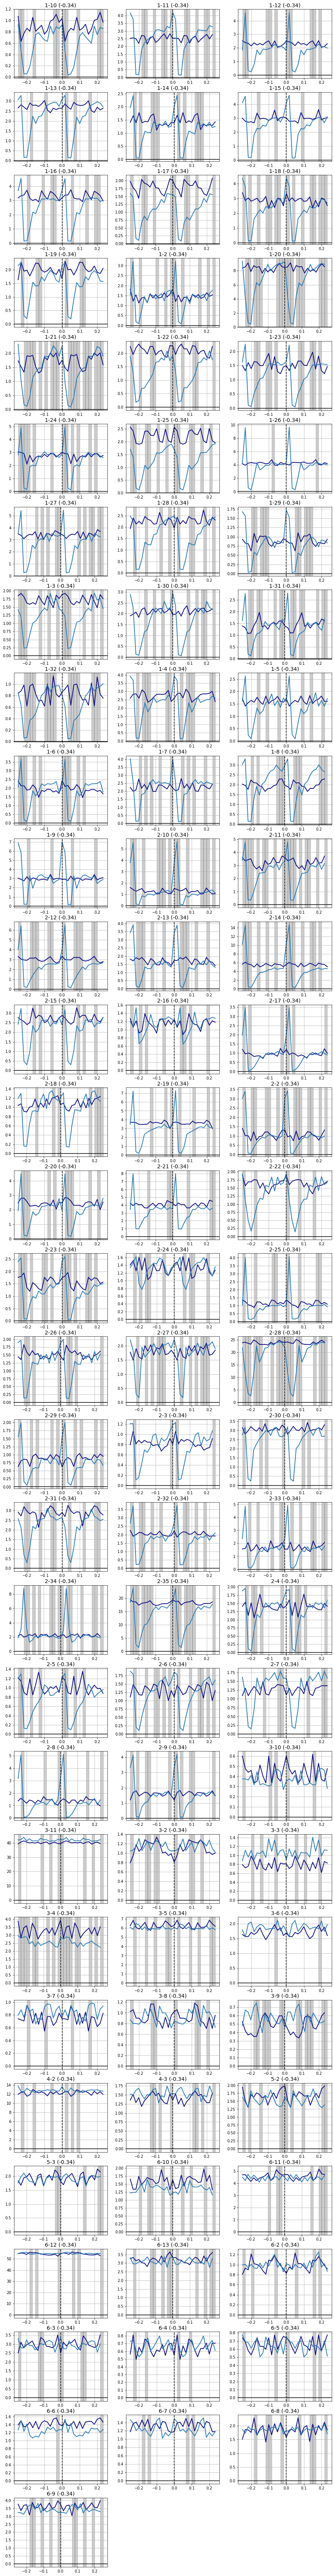

In [17]:
units_to_plot = unit_names
#units_to_plot = [u for u in unit_names if int(u[0]) > 2]

cols = 3
rows = int(np.ceil(len(units_to_plot)/cols))
fig  = plt.figure(figsize=(15, rows*4))

coll_diffs = []
coll_sil_z = []
coll_bgr_z = []
for i, unit_name in enumerate(units_to_plot[:]):
    strain = get_spike_times_at(tl, spike_times[unit_name], periods_bgr, mode='sequence')
    strain = np.array([item for sublist in strain for item in sublist])  # flatten to one array
    #bins, counts_bgr = get_spike_counts(strain, adjusted_pulses, hw=hw, bin_count=bc)
    bins, counts_bgr = get_spike_counts(spike_times[unit_name], p_bgr, hw=hw, bin_count=bc)
    bins, counts_sil = get_spike_counts(spike_times[unit_name], p_sil, hw=hw, bin_count=bc)
    
    with h5py.File(h5_file, 'r') as f:
        shuffled_sil = np.array(f['units'][unit_name]['psth_shuffled_micro_in_silence'])
        shuffled_bgr = np.array(f['units'][unit_name]['psth_shuffled_micro_in_BGR'])
        profiles = np.array(f['units'][unit_name]['psth_profiles_silence'])

    # for silence
    fr_sil_mean = shuffled_sil[:, 1]
    fr_sil_std  = shuffled_sil[:, 2]
    fr_sil_prof = profiles.mean(axis=0)
    #prof_sil_z = (fr_sil_prof - fr_sil_mean)/fr_sil_std  # z-scored
    #prof_sil_z /= np.max(np.abs(prof_sil_z), axis=0)      # put bw -1 and 1
    
    # remove non-significant bins
    idxs_non_sign = np.where((fr_sil_prof > shuffled_sil[:, 3]) & (fr_sil_prof < shuffled_sil[:, 4]))[0]
    idxs_sign = np.array([x for x in range(bc - 1) if x not in idxs_non_sign])
        
    # for BGR
    fr_bgr_mean = shuffled_bgr[:, 1]
    fr_bgr_std  = shuffled_bgr[:, 2]
    fr_bgr_prof = counts_bgr
    #prof_bgr_z = (fr_bgr_prof - fr_bgr_mean)/fr_bgr_std  # z-scored
    #prof_bgr_z /= np.max(np.abs(prof_bgr_z), axis=0)      # put bw -1 and 1
    
    # corr for significant bins
    #if len(idxs_sign) > 0:
    #np.corrcoef(prof_bgr_z, prof_sil_z)[0][1]
    
    # plotting
    ax = fig.add_subplot(rows, cols, i+1)
    ax.plot(bins[:-1], counts_sil, lw=2, color='navy', alpha=0.95)#, ls='--')
    ax.plot(bins[:-1], counts_bgr, lw=2, color='tab:blue', alpha=0.95)#, ls='--')
    for s_bin in idxs_sign:
        ax.axvspan(bins[s_bin], bins[s_bin+1], alpha=0.2, color='black')
    #ax.plot(bins[:-1], prof_bgr_z - prof_sil_z, lw=2, color='black', alpha=0.8)
    #if len(idxs_sign) > 0:
    #    ax.scatter(bins[:-1][idxs_sign], prof_sil_z[idxs_sign], s=50, color='black')
    ax.axvline(0, color='black', ls='--')
    ax.axhline(0, color='black')
    ax.set_title("%s (%.2f)" % (unit_name, np.corrcoef(prof_bgr_z, prof_sil_z)[0][1]), fontsize=14)
    ax.grid()
    #ax.set_ylim(-2, 2)
    coll_sil_z.append(prof_sil_z)
    coll_bgr_z.append(prof_bgr_z)
    coll_diffs.append(np.gradient(prof_bgr_z) - np.gradient(prof_sil_z))

coll_sil_z = np.array(coll_sil_z)
coll_bgr_z = np.array(coll_bgr_z)
coll_diffs = np.array(coll_diffs)

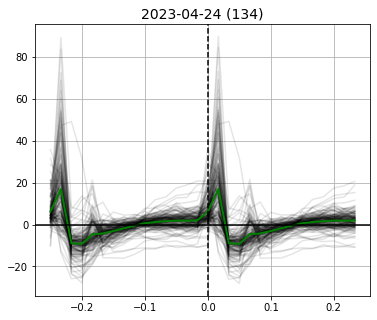

In [244]:
#var = coll_diffs
var = profile_mx

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for df in var:
    ax.plot(bins[:-1], df, color='black', alpha=0.1)
ax.plot(bins[:-1], var.mean(axis=0), lw=2, color='green')
ax.axvline(0, color='black', ls='--')
ax.axhline(0, color='black')
ax.set_title("%s (%d)" % (session[-19:-9], len(units_to_plot)), fontsize=14)
ax.grid()

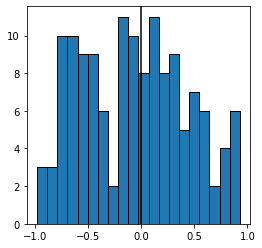

In [213]:
w_l, w_r = 15, 20
corr_coeffs = np.zeros(len(coll_sil_z))
for i in range(len(coll_sil_z)):
    corr_coeffs[i] = np.corrcoef(coll_bgr_z[i][w_l:w_r], coll_sil_z[i][w_l:w_r])[0][1]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.hist(corr_coeffs, bins=20, edgecolor='black', color='tab:blue')
ax.axvline(0, color='black')

## Profile stats across sessions

In [473]:
# All PPC
sessions_1 = [s for s in selected_008229.keys()]
sessions_1.sort()
sessions_2 = [s for s in selected_009266.keys()]
sessions_2.sort()
sessions_3 = [s for s in selected_009265.keys()]
sessions_3.sort()
all_PPC = sessions_1 + sessions_2[:-5] + sessions_3[5:-2]

# all A1
sessions_1 = [s for s in selected_009265.keys()]
sessions_1.sort()
sessions_2 = [s for s in selected_009266.keys()]
sessions_2.sort()
all_A1 = sessions_1[5:-2] + sessions_2


# all HPC
sessions_1 = [s for s in selected_009266.keys()]
sessions_1.sort()
all_HPC = sessions_1[-5:]


selected = all_PPC
selected

['008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-18_14-36-18',
 '008229_hippoSIT_2022-05-20_15-54-39',
 '009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-20_15-24-14',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009265_hippoSIT_2023-02-28_13-16-10',
 '009265_hippoSIT_2023-02-28_20-45-04',
 '009265_hippoSIT_2023-03-01_10-46-12',
 '009265_hippoSIT_2023-03-02_09-32-54',
 '009265_hippoSIT_2023-03-02_16-27-42',
 '009265_hippoSIT_2023-03-02_20-11-35',
 '009265_hippoSIT_2023-03-03_09-37-07',
 '009265_hippoSIT_2023-03-03_16-00-47',


In [480]:
# build response profile matrix for MANY sessions
hw, bc = 0.25, 31
bins = np.linspace(-hw, hw, bc)

profile_mx = []
for session in selected:
    animal      = session.split('_')[0]
    h5_file     = os.path.join(source, animal, session, session + '.h5')
    
    with h5py.File(h5_file, 'r') as f:
        for i, unit_name in enumerate(f['units']):
            # area filter
            if int(unit_name[0]) < 3:
                continue

            event_name = 'BGR'  #'silence'
            #event_name = 'silence'  #'silence'
            shuffled = np.array(f['units'][unit_name]['psth_shuffled_micro_in_%s' % event_name])
            profiles = np.array(f['units'][unit_name]['psth_profiles_%s' % event_name])

            fr_mean = shuffled[:, 1]
            fr_std  = shuffled[:, 2]
            fr_prof = profiles.mean(axis=0)
            #non_sign_idxs = np.where( (fr_prof > shuffled[:, 3]) & (fr_prof < shuffled[:, 4]) )[0]
            non_sign_idxs = np.where( (fr_prof > 0.9*shuffled[:, 3]) & (fr_prof < 1.1*shuffled[:, 4]) )[0]
            
            resp_profile = (fr_prof - fr_mean)/fr_std  # z-scored
            #resp_profile[non_sign_idxs] = 0  # clean non-significant bins
            if len(non_sign_idxs) == 30:
                continue
            profile_mx.append( resp_profile )
            
profile_mx = np.array(profile_mx)
profile_mx.shape

(188, 30)

In [482]:
#profile_mx_A1_BGR  = profile_mx.copy()
#profile_mx_HPC_BGR = profile_mx.copy()
profile_mx_PPC_BGR = profile_mx.copy()
#profile_mx_A1_sil  = profile_mx.copy()
#profile_mx_HPC_sil = profile_mx.copy()
#profile_mx_PPC_sil = profile_mx.copy()

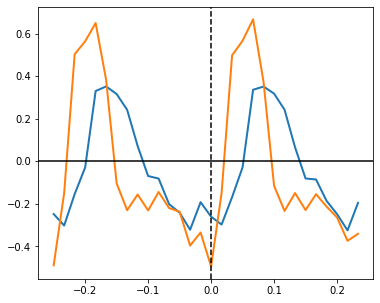

In [481]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i, var in enumerate([profile_mx, profile_mx_PPC_BGR]):
    #for df in var:
    #    ax.plot(bins[:-1], df, color='black', alpha=0.1)
    if i == 0:
        ax.plot(bins[:-1], var.mean(axis=0), lw=2)
    else:
        ax.plot(bins[:-1], var.mean(axis=0), lw=2)
ax.axvline(0, color='black', ls='--')
ax.axhline(0, color='black')

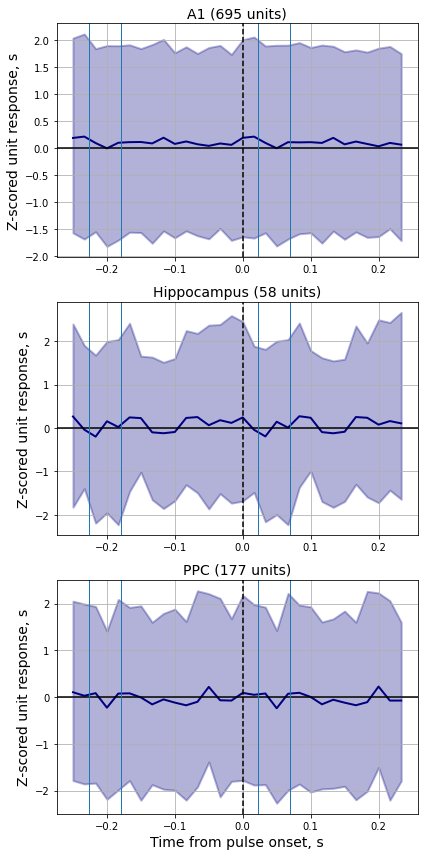

In [485]:
titles = ['A1', 'Hippocampus', 'PPC']

fig, axes = plt.subplots(3, 1, figsize=(6, 12))
#for j, var in enumerate([profile_mx_A1_BGR, profile_mx_HPC_BGR, profile_mx_PPC_BGR]):
for j, var in enumerate([profile_mx_A1_sil, profile_mx_HPC_sil, profile_mx_PPC_sil]):
    prof_mean = var.mean(axis=0)
    prof_sem  = stats.sem(var, axis=0)
    confidence_low  = np.zeros(var.shape[1])
    confidence_high = np.zeros(var.shape[1])
    for i, col in enumerate(var.T):
        confidence_low[i]  = np.percentile(col, 5)
        confidence_high[i] = np.percentile(col, 95)  
    
    ax = axes[j]
    #for df in var:
    #    ax.plot(bins[:-1], df, color='black', alpha=0.1)
    ax.plot(bins[:-1], prof_mean, lw=2, color='navy')
    ax.fill_between(bins[:-1], confidence_low, confidence_high, lw=2, alpha=0.3, color='navy')
    ax.axvline(0, color='black', ls='--')
    ax.axhline(0, color='black')
    #for t_AEP in [15, 28, 75, 100, 200]:
    for t_AEP in [28, 75]:
        ax.axvline(t_AEP/1000 - 0.005, lw=1)
        ax.axvline(t_AEP/1000 - 0.005 - 0.25, lw=1)
    ax.grid()
    if j == 2:
        ax.set_xlabel('Time from pulse onset, s', fontsize=14)
    ax.set_ylabel('Z-scored unit response, s', fontsize=14)
    ax.set_title("%s (%d units)" % (titles[j], len(var)), fontsize=14)
    #ax.set_ylim(-0.7, 0.7)
    
fig.tight_layout()
fig.savefig(os.path.join(report, 'Hall', 'avg_resp_prof_silence.png'), dpi=500)

## Modulation at diff phases

In [226]:
# just counts of significant bins
high_counts = np.array([len(np.where(profile_mx[:, bin_id] > 0)[0]) for bin_id in range(bc - 1)])
low_counts  = np.array([len(np.where(profile_mx[:, bin_id] < 0)[0]) for bin_id in range(bc - 1)])

In [230]:
# sum of actual z-scored values
high_counts = np.array([profile_mx[profile_mx[:, bin_id] > 0][:, bin_id].mean() for bin_id in range(bc - 1)])
low_counts  = np.array([profile_mx[profile_mx[:, bin_id] < 0][:, bin_id].mean() for bin_id in range(bc - 1)])

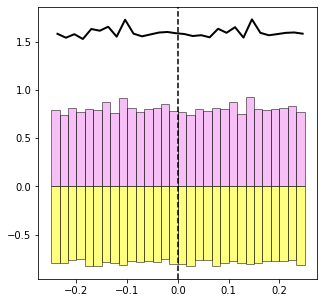

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.hist(bins[:-1], bins=bins, weights=high_counts, edgecolor='black', color='violet', alpha=0.5, label='All')
ax.hist(bins[:-1], bins=bins, weights=low_counts, edgecolor='black', color='yellow', alpha=0.5, label='All')
ax.axvline(0, color='black', ls='--')
ax.plot(bins[:-1] + 0.0125, high_counts - low_counts, color='black', lw=2)

## Component variations (very rough)

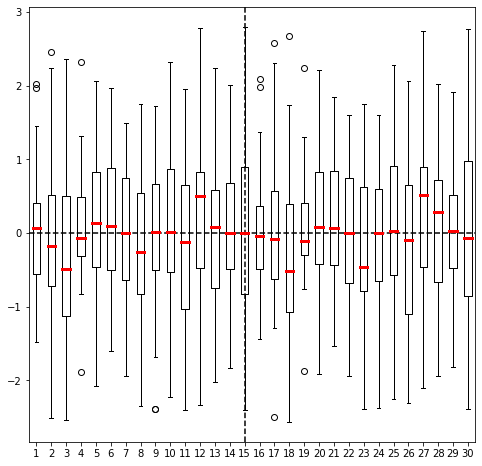

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

bp = ax.boxplot([profile_mx[:, i] for i in range(profile_mx.shape[1])])
ax.axhline(0, color='black', ls='--')
ax.axvline(15, color='black', ls='--')
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
#ax.set_xticklabels(bins[:-1])

## PCA on profiles

In [180]:
# PCA on GLM fits
pca = decomposition.PCA(n_components=3)
pca.fit(profile_mx)
X = pca.transform(profile_mx)

#pca.fit(coll_bgr_z)
#X = pca.transform(coll_bgr_z)

#pca.fit(coll_sil_z)
#X = pca.transform(coll_sil_z)

#pca.fit(coll_diffs)
#X = pca.transform(coll_diffs)

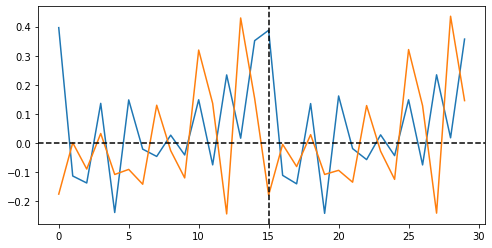

In [181]:
# plot PCA components
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for comp in pca.components_[:2]:
    ax.plot(comp)
    
ax.axhline(0, color='black', ls='--')
ax.axvline(15, color='black', ls='--')

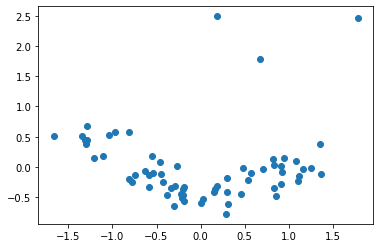

In [130]:
plt.scatter(X[:, 0], X[:, 1])
#plt.scatter(X[:, 0], X[:, 2])

Text(0, 0.5, 'Variance Explained')

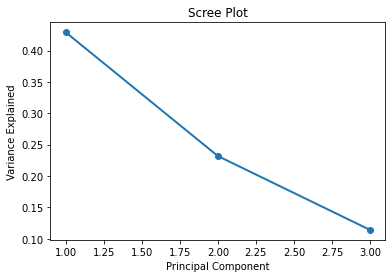

In [127]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')